In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, datasets, transforms
from torch.autograd import grad
import torchvision

torch.manual_seed(50)

In [2]:
interval = 30
class_num = 10
protected_layers = []  # No specific layers to protect initially
dst = datasets.CIFAR10("~/.torch", download=True)
tp = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor()
])
tt = transforms.ToPILImage()

device = "cpu"
if torch.cuda.is_available():
    device = "cuda:4"  # Changed to cuda:0 for general usage
print("Running on %s" % device)

Files already downloaded and verified
Running on cuda:4


In [3]:
def label_to_onehot(target, num_classes=class_num):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

In [4]:
def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

In [5]:
def weights_init(m):
  if hasattr(m, "weight"):
      m.weight.data.uniform_(-0.5, 0.5)
  if hasattr(m, "bias"):
      m.bias.data.uniform_(-0.5, 0.5)

In [6]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(768, class_num)
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [7]:
net = LeNet().to(device)
net.apply(weights_init)
criterion = cross_entropy_for_onehot

GT label is 2. 
Onehot label is 2.


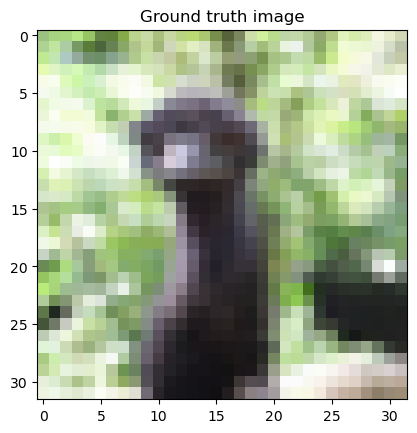

In [8]:
img_index = 55
gt_data = tp(dst[img_index][0]).to(device)
gt_data = gt_data.view(1, *gt_data.size())
gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
gt_label = gt_label.view(1, )
gt_onehot_label = label_to_onehot(gt_label, num_classes=class_num)
plt.imshow(tt(gt_data[0].cpu()))
plt.title("Ground truth image")
print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())

In [9]:
out = net(gt_data)
y = criterion(out, gt_onehot_label)
dy_dx = torch.autograd.grad(y, net.parameters())

In [10]:
flattened_grads = torch.cat([g.view(-1) for g in dy_dx])
flattened_grads[-5:]

tensor([6.1626e-04, 4.2538e-05, 3.7137e-04, 1.9220e-03, 8.7746e-04],
       device='cuda:4')

In [11]:
total_params = len(flattened_grads)
exposed_params = int(total_params * (1/3))

In [12]:
total_params

19438

In [13]:
exposed_params

6479

In [14]:
mask = torch.ones(total_params, device=flattened_grads.device)

In [15]:
mask[exposed_params:2*exposed_params] = 0

In [16]:
mask.count_nonzero()

tensor(12959, device='cuda:4')

In [17]:
def mask_gradients(dy_dx, exposure_ratio=1/3):
    flattened_grads = torch.cat([g.view(-1) for g in dy_dx])
    total_params = len(flattened_grads)
    exposed_params = int(total_params * exposure_ratio)

    mask = torch.zeros(total_params, device=flattened_grads.device)
    mask[2*exposed_params:3*exposed_params] = 1

    masked_grads = []
    start = 0
    for g in dy_dx:
        numel = g.numel()
        g_flat = g.view(-1)
        masked_g_flat = g_flat * mask[start:start+numel]
        masked_grads.append(masked_g_flat.view_as(g))
        start += numel

    return tuple(masked_grads)

In [18]:
dy_dx = mask_gradients(dy_dx)

In [19]:
original_dy_dx = list((_.detach().clone() for _ in dy_dx))

Dummy label is 7.


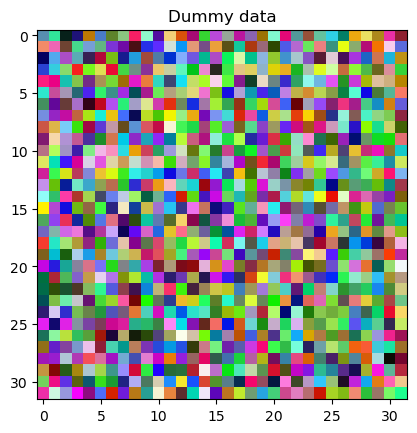

In [20]:
dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

plt.imshow(tt(dummy_data[0].cpu()))
plt.title("Dummy data")
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

In [21]:
optimizer = torch.optim.LBFGS([dummy_data, dummy_label])

In [22]:
history = []
losses = []
for iters in range(30*interval):
    def closure():
        optimizer.zero_grad()

        pred = net(dummy_data)
        dummy_onehot_label = F.softmax(dummy_label, dim=-1)
        dummy_loss = criterion(pred, dummy_onehot_label)
        dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)

        dummy_dy_dx = mask_gradients(dummy_dy_dx)

        grad_diff = 0
        grad_count = 0

        for gx, gy in zip(dummy_dy_dx, original_dy_dx):
            grad_diff += ((gx - gy) ** 2).sum()
            grad_count += gx.nelement()

        grad_diff.backward()
        losses.append(grad_diff.item())
        return grad_diff

    optimizer.step(closure)
    if iters % interval == 0:
        print(f"{iters}, {losses[iters]}")
    history.append(tt(dummy_data[0].cpu()))

plt.figure(figsize=(12, 8))

0, 323.4707946777344
30, 0.053286392241716385
60, 0.011551234871149063
90, 0.004675103351473808
120, 0.0028147059492766857
150, 0.0018455820390954614
180, 0.001396676991134882
210, 0.0011752636637538671
240, 0.0009955763816833496
270, 0.0009029487264342606
300, 0.0008169954526238143
330, 0.0007531705778092146
360, 0.0007021838100627065
390, 0.0006626902613788843
420, 0.000626082590315491
450, 0.0006011269870214164
480, 0.0005695936852134764
510, 0.0005436597275547683
540, 0.0005152156227268279
570, 0.0004998657386749983
600, 0.00047961159725673497
630, 0.00046182124060578644
660, 0.0004531071172095835
690, 0.00043918195297010243
720, 0.00043253652984276414
750, 0.0004166611470282078
780, 0.0004105662228539586
810, 0.0004011255514342338
840, 0.0003922086616512388
870, 0.0003828235203400254


<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

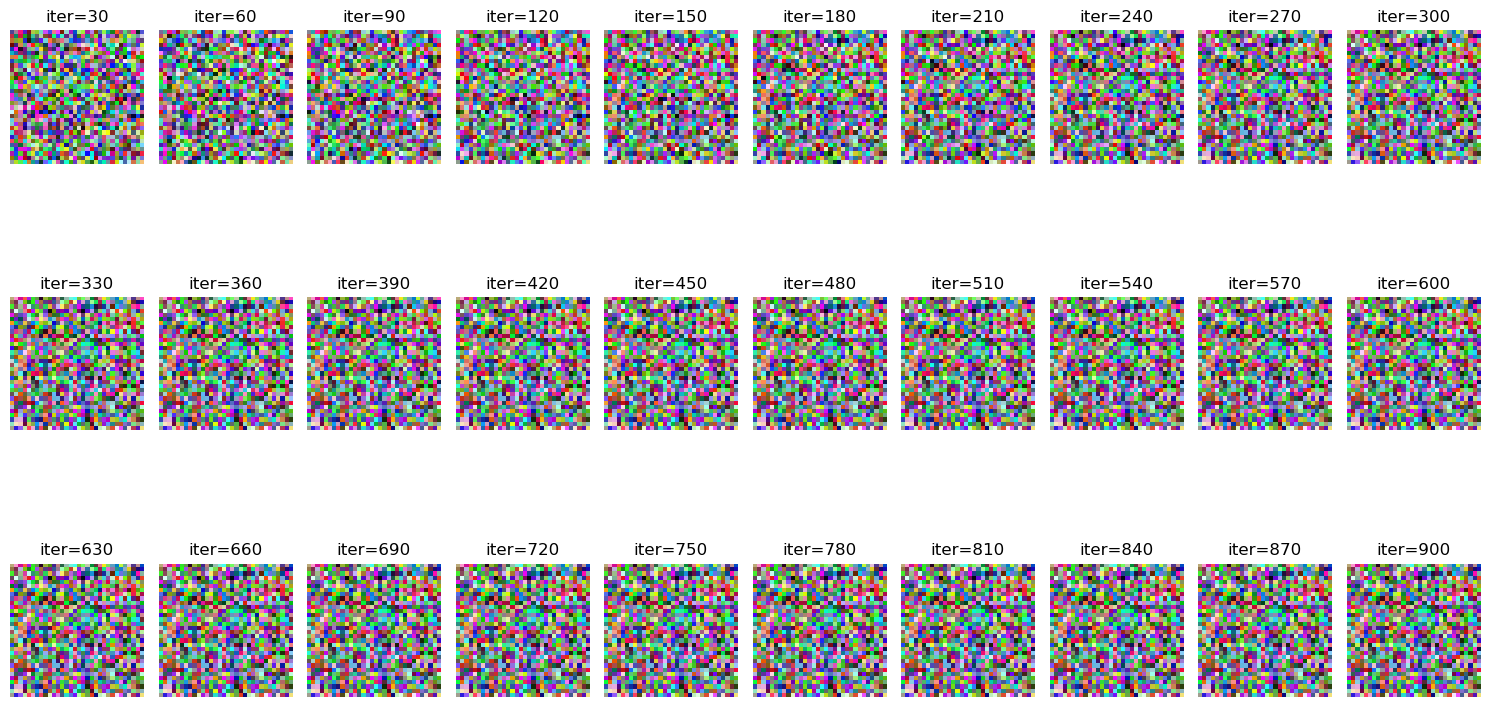

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data: replace this with your actual image data
# For demonstration, let's generate 900 random images (28x28 pixels)
# history = np.random.rand(900, 28, 28)

# Set the interval
interval = 30

# Create a figure
plt.figure(figsize=(15, 9))

for i in range(30):
    ite_num = i * interval + interval - 1
    plt.subplot(3, 10, i + 1)
    plt.imshow(history[ite_num])  # Assuming the images are grayscale
    plt.title("iter=%d" % (ite_num + 1))
    plt.axis('off')

# Show the plot
plt.tight_layout()
plt.show()


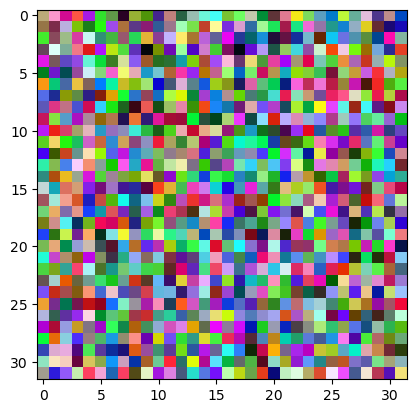

In [28]:
plt.imshow(history[899])

GT label is 2. 
Onehot label is 2.


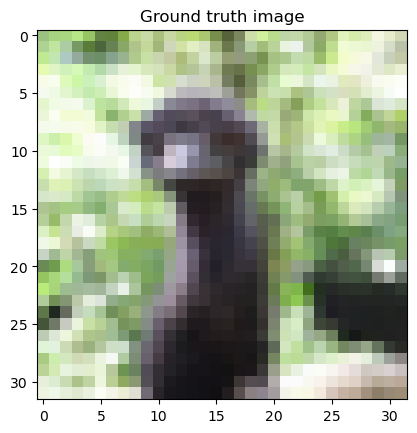

In [17]:
plt.imshow(tt(gt_data[0].cpu()))
# file_gt = "gt.png"
# plt.savefig(file_gt)
plt.title("Ground truth image")
print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())